First the data is imported and classifications updated

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Met = pd.read_csv('Met430k-2.csv', sep = ',', engine = 'python')
Classes = pd.read_csv('classesCleaned.csv', sep = ',', engine = 'python')


In [137]:
Met.count()

Unnamed: 0             427592
Unnamed: 0.1           427592
Object ID              427592
object_number          427592
artist_nationality     192674
object_begin_date      427592
object_end_date        427592
credit_line            426965
country                427592
classification         374667
medium                 421276
artist_display_name    256333
artist_display_bio     234364
culture                186901
object_name            424522
link                   427592
acq_year               396331
dtype: int64

In [138]:
Classes.count()

0        427591
Metal    427591
dtype: int64

In [139]:
ClusterData=Met
ClusterData.loc[1:,"classification"]=Classes["Metal"]
ClusterData.count()

Unnamed: 0             427592
Unnamed: 0.1           427592
Object ID              427592
object_number          427592
artist_nationality     192674
object_begin_date      427592
object_end_date        427592
credit_line            426965
country                427592
classification         427591
medium                 421276
artist_display_name    256333
artist_display_bio     234364
culture                186901
object_name            424522
link                   427592
acq_year               396331
dtype: int64

The lower estimate for the objects creation date has a number of repetitions - indicating accuracy varies and often to nearest 100 years. The data has a large range with a long tail of historic/prehistoric items. This skews the standard deviation, often used to normalise data for clustering. We can mitigate this by applying a Tukey fence - ignoring data which sits outside 1.5x interquartile range from the upper or lower quartile.

In [140]:
ClusterData.object_begin_date.value_counts().head(10)

 1800    20490
 1700    14472
 1900     6494
-500      6231
 1600     6142
-530      6119
 1890     5314
 1850     5083
 1500     5033
 1880     4422
Name: object_begin_date, dtype: int64

In [141]:
ClusterData.object_begin_date.describe()

count    427592.000000
mean       1314.351108
std        1664.265032
min     -400000.000000
25%        1530.000000
50%        1797.000000
75%        1890.000000
max        5000.000000
Name: object_begin_date, dtype: float64

First we get rid of some erronous dates

In [142]:
mistakes = ClusterData.loc[ClusterData.object_begin_date > 2019]
ClusterData=ClusterData.loc[ClusterData.object_begin_date <= 2019]
mistakes.object_begin_date.describe()

count       2.0
mean     5000.0
std         0.0
min      5000.0
25%      5000.0
50%      5000.0
75%      5000.0
max      5000.0
Name: object_begin_date, dtype: float64

In [143]:
IQR = np.percentile(ClusterData.object_begin_date,75)-np.percentile(ClusterData.object_begin_date,25)
print(IQR)
cutoff = np.percentile(ClusterData.object_begin_date,25)-1.5*IQR
print(cutoff)

360.0
990.0


In [144]:
outliers = ClusterData.loc[ClusterData.object_begin_date < cutoff]
cutData = ClusterData.loc[(ClusterData.object_begin_date >= cutoff)]
cutData.object_begin_date.describe()

count    347108.000000
mean       1787.881991
std         167.155292
min         990.000000
25%        1700.000000
50%        1833.000000
75%        1907.000000
max        2018.000000
Name: object_begin_date, dtype: float64

In [145]:
outliers.object_begin_date.describe()

count     80482.000000
mean       -728.015246
std        3075.130237
min     -400000.000000
25%       -1353.000000
50%        -530.000000
75%           0.000000
max         980.000000
Name: object_begin_date, dtype: float64

By rerunning statistics separately on the core and outlier data, we get a more nuanced picture of the distribution:
about 80% of the artwork comes from the last millenium, 5% comes from the the 1st millenium a.d. and the rest stretches out into prehistory. It is also apparent that the cut data still has a skewed distribution. We can plot a histogram to get a better sense of the distribution

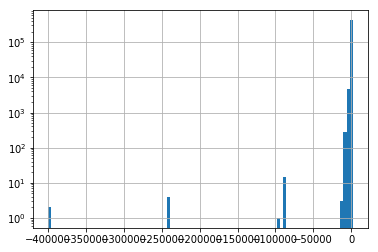

In [159]:
ClusterData.object_begin_date.hist(bins=100,log=True)

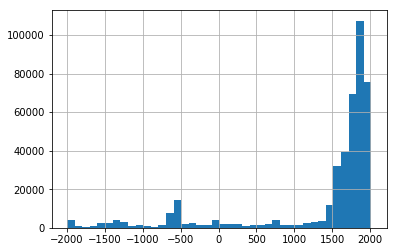

In [146]:
ClusterData.loc[(ClusterData.object_begin_date >= -2000)].object_begin_date.hist(bins=40)

There are some concentrations of datapoints in pre-history, but this may reflect the tendency for age estimates to be bounded at rounded dates. Interestingly by plotting more recent artwork on a log chart, there appear to be a power-law type relationship on the amount of art present, with a noticeable step-up around 1500 - an American effect?

(array([  1214.,   1840.,   2374.,   2729.,   3502.,  10332.,  20562.,
         31342.,  40361.,  69641., 105880.,  57314.]),
 array([1000.        , 1084.83333333, 1169.66666667, 1254.5       ,
        1339.33333333, 1424.16666667, 1509.        , 1593.83333333,
        1678.66666667, 1763.5       , 1848.33333333, 1933.16666667,
        2018.        ]),
 <a list of 12 Patch objects>)

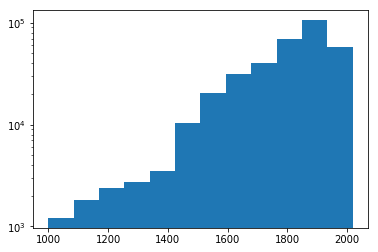

In [147]:
plt.hist(ClusterData.loc[ClusterData.object_begin_date >= 1000].object_begin_date,bins=12,log=True)

The skewness of the data possibly reflects both a survival/interest bias but also the increasing speed of changes in artwork. Either way, when normalising the distance function in our clustering a linear scale function may not be appropriate - 100 years of distance in modern times is far more signfiicant than 100 years of distance in historical times.

In [151]:
type(ClusterData)

pandas.core.frame.DataFrame

In [155]:
np.exp(10)

22026.465794806718

In [156]:
for i in ClusterData.index:
        ClusterData.at[i, 'normalised_date'] = np.exp(ClusterData.at[i, 'object_begin_date']/1000 + 2)/np.exp(4)

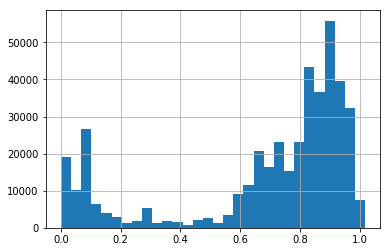

In [163]:
ClusterData.normalised_date.hist(bins=30,log=False)

0=-2000, 0.2= 400, 0.4 =1000, 0.6=1500, 0.8= 1776 1 =2000

In [115]:
ClusterData.classification.value_counts().head(100)

Prints            103631
Unknown/Other      52925
Photographs        35188
Drawings           29579
Textiles           29442
Ceramics           24441
Vases              20531
Books              14037
Paintings          11342
Metalwork          10553
Glass               8234
Sculpture           6170
Negatives           6162
Wood                3239
Sword               3236
Stone               3136
|                   3064
Silver              2417
Ornament            2245
Medals              2174
Woodwork            2167
Jewelry             2016
Ornaments           1966
Miscellaneous       1927
Furniture           1837
Stucco              1793
Aerophone           1767
Metal               1569
Gems                1535
Terracottas         1534
                   ...  
Crèche               335
Pottery              306
Ephemera             306
Seals                287
Basketry             283
Media                273
Hardstone            266
Beads                266
Chess                260


In [119]:
sum(ClusterData.classification.value_counts().head(10))/ClusterData.classification.count()

0.77567061905096

In [121]:
sum(ClusterData.classification.value_counts().head(20))/ClusterData.classification.count()

0.8693982553380575

In [123]:
sum(ClusterData.classification.value_counts().head(50))/ClusterData.classification.count()

0.9560373254753385

In [124]:
ClusterData.medium.value_counts().head(100)

Terracotta                                                       22424
Etching                                                          15977
Commercial color lithograph                                      13942
Engraving                                                        10357
Gelatin silver print                                              9113
Albumen photograph                                                7316
Silk                                                              7273
Glass                                                             6009
Film negative                                                     5889
Bronze                                                            5873
Lithograph                                                        5868
Faience                                                           4747
Albumen silver print from glass negative                          4720
Woodcut                                                           4414
silk  

In [127]:
sum(ClusterData.medium.value_counts().head(100))/ClusterData.medium.count()

0.5496517705816167

In [ ]:
sum(ClusterData.medium.value_counts().head(100))/ClusterData.medium.count()

In [ ]:
ClusterDataColumns = ClusterData[["Unnamed: 0","object_begin_date","classification","medium"]]

import scipy
from sklearn.cluster import DBSCAN
from sklearn import metrics
import functools


def metricFunction(x,y,mu):
    numeric = abs(x[1]-y[1])  #this will be the date distance needs normalisation
    categorical = int(x[2]!=y[2]) + int(x[3]!=y[3])
    distance = numeric + mu * categorical
    return distance

def dbscanFit(data, eps, minSamples,mu):
    metric_weighted=functools.partial(metricFunction,mu=mu)
    #DBSCAN for non Year Data
    dbscan = DBSCAN(eps = eps, metric = metric_weighted, min_samples = minSamples)
    dbscan.fit(data)
    dbscan_labels = dbscan.labels_
    silh = metrics.silhouette_score(data, dbscan_labels)
    print("Silhouette Score: ", silh)
    clusters = pd.DataFrame(dbscan_labels)
    clusters['Count'] = 1
    clusters.columns = ['Cluster ID', 'Count']
    print(clusters.groupby('Cluster ID').sum().head())
    
    return dbscan_labels
